## 1차 과제 - 고객 유지/이탈 자유 분석
- 주제: 가입 고객 이탈 데이터를 분석하여 기업에 인사이트 제공
- 데이터: Customer Churn Data(train data가 따로 있으나 너무 커서 test data만 사용, 예측 성능 향상을 원한다면 train data 사용해도 무방)
https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset?select=customer_churn_dataset-training-master.csv
- 사용 라이브러리: 자유

본 과제는 여러분들의 실력을 확인하고자 출제한 과제로 어떠한 가이드라인도 제공하거나 제약하지 않으며 자유롭게 분석하시면 됩니다.

분석이나 예측 어느 쪽이든 상관없으며 몇가지 조건만 유의하여 주시기 바랍니다.

### 조건
1. 기본적인 분석 과정은 EDA(데이터 탐색) > 전처리 > 분석(예측) 진행 > 결과 해석 으로 진행되지만 약간의 수정 허용
2. EDA 과정에서 최소 2개의 시각화 모형(그래프) 사용
3. 분석 및 예측 시 최소 2개의 모형(모델) 사용
4. 전처리는 자유롭게 진행하며 추가적인 데이터 사용이 필요하다면 허용

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [27]:
file_path = 'customer_churn_dataset-testing-master.csv'
df = pd.read_csv(file_path)
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


<Figure size 1000x600 with 0 Axes>

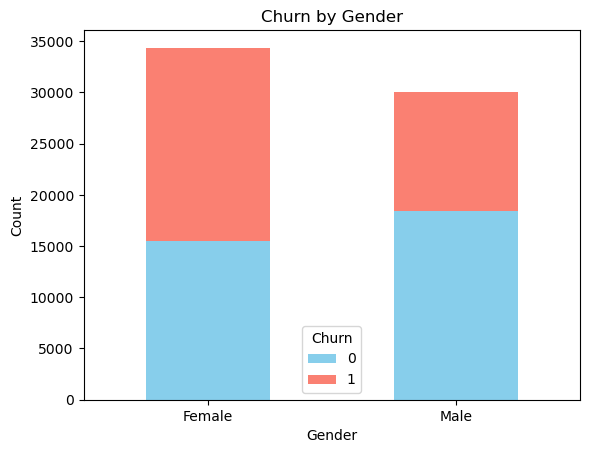

<Figure size 1000x600 with 0 Axes>

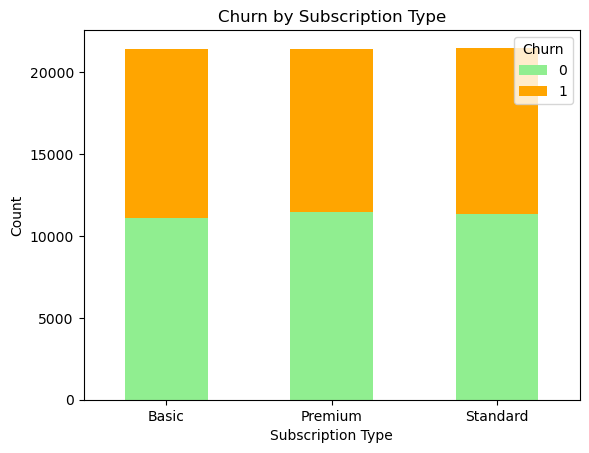

In [29]:
# 시각화를 위한 데이터 준비
churn_gender = df.groupby(['Gender', 'Churn']).size().unstack()
churn_subscription = df.groupby(['Subscription Type', 'Churn']).size().unstack()

# 시각화 1: 성별에 따른 이탈 여부 분포
plt.figure(figsize=(10, 6))
churn_gender.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Churn by Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# 시각화 2: 구독 유형에 따른 이탈 여부 분포
plt.figure(figsize=(10, 6))
churn_subscription.plot(kind='bar', stacked=True, color=['lightgreen', 'orange'])
plt.title('Churn by Subscription Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

- 성별에 따른 이탈 여부: 남성과 여성 모두 유사한 비율로 이탈하고 있으며, 이탈 여부에 성별이 큰 영향을 미치지 않는 것으로 보입니다.
- 구독 유형에 따른 이탈 여부: 기본 구독(Basic) 고객들이 다른 구독 유형(Standard, Premium)에 비해 이탈률이 높습니다. 반면 프리미엄 구독(Premium) 고객들의 이탈률은 상대적으로 낮은 편입니다.

In [30]:
# 범주형 변수 인코딩
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df_encoded = pd.get_dummies(df, columns=['Subscription Type', 'Contract Length'], drop_first=True)

In [31]:
# 이상치 처리: IQR을 사용하여 이상치 제거 (Age, Usage Frequency, Total Spend)
Q1 = df_encoded[['Age', 'Usage Frequency', 'Total Spend']].quantile(0.25)
Q3 = df_encoded[['Age', 'Usage Frequency', 'Total Spend']].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위를 벗어난 값 제거
df_cleaned = df_encoded[~((df_encoded[['Age', 'Usage Frequency', 'Total Spend']] < (Q1 - 1.5 * IQR)) | 
                      (df_encoded[['Age', 'Usage Frequency', 'Total Spend']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [32]:
# 추가 변수 생성 (월별 지출, 지연 비율)
df_cleaned['Monthly Spend'] = df_cleaned['Total Spend'] / (df_cleaned['Tenure'] + 1)
df_cleaned['Delay Rate'] = df_cleaned['Payment Delay'] / (df_cleaned['Tenure'] + 1)

In [33]:
X = df_cleaned.drop(columns=['CustomerID', 'Churn'])
y = df_cleaned['Churn']

In [34]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
# 모델 1: 로지스틱 회귀
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)

In [43]:
# 모델 2: 랜덤 포레스트
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

In [44]:
print(f'로지스틱 회귀의 정확도는 {lr_acc * 100:.1f}%입니다.')
print(f'랜덤 포레스트의 정확도는 {rf_acc * 100:.1f}%입니다.')

로지스틱 회귀의 정확도는 79.8%입니다.
랜덤 포레스트의 정확도는 99.7%입니다.


-> 랜덤 포레스트 모델이 더 높은 정확도를 가지고 있다는 것을 알 수 있습니다.